In [1]:
from pathlib2 import Path

In [188]:
data_path = Path('data')
model_dir = Path('experiments')
save_dir = Path('Visulization')

wrap_size = 32
font = 'STSONG'

## load the model

In [189]:
import torch
import pickle

from utils import load_best_checkpoint
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

from model import create_AutoEncoder
import yaml

In [244]:
config = yaml.load(open('config/config.yml', 'r'), Loader=yaml.FullLoader)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_AutoEncoder(config['model'])
model = model.to(device)
load_best_checkpoint(model_dir, model)
model = model.Encoder
model.eval()

loading best checkpoint at experiments/best.pth.tar


Sequential(
  (block1): Sequential(
    (conv1): Conv2d(1, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (maxpool1): AdaptiveMaxPool2d(output_size=8)
  )
  (block2): Sequential(
    (conv2): Conv2d(384, 768, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (maxpool2): AdaptiveMaxPool2d(output_size=2)
  )
  (block3): Sequential(
    (conv3): Conv2d(768, 192, kernel_size=(1, 1), stride=(1, 1))
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (droupout): Sequential(
    (0): Reshape()
    (1): Dropout(p=0.1, inplace=False)
  )
)

In [245]:
img_transforms = transforms.Compose(
            [transforms.Resize((wrap_size, wrap_size)),
             transforms.ToTensor()])

## Analyze

In [238]:
import pickle
import numpy as np
from transformers import BertTokenizer, BertModel

In [249]:
lm = BertModel.from_pretrained('bert-base-chinese')
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
lm = lm.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [209]:
hanzi_list = '吆 诬 远 恶 云 辽'.split()

### Analyze using Integraded Gradients

In [246]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

In [259]:
class CosModel(torch.nn.Module):
    def __init__(self, model, linear_layer):
        super(CosModel, self).__init__()
        self.model = model
        self.linear_layer = linear_layer
        self.cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    
    def forward(self, x, y):
        x = self.model(x)
        x = self.linear_layer(x)
        x = self.cosine_similarity(x, y)
        return x

In [260]:
linear_layer = torch.nn.Linear(768, 768, bias=False)
weights = pickle.load(open(save_dir/'xingsheng_matrix.pkl', 'rb'))
linear_layer.weight.data = torch.from_numpy(weights)
linear_layer.to(device)
cos_model = CosModel(model, linear_layer)
cos_model.eval()

CosModel(
  (model): Sequential(
    (block1): Sequential(
      (conv1): Conv2d(1, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (maxpool1): AdaptiveMaxPool2d(output_size=8)
    )
    (block2): Sequential(
      (conv2): Conv2d(384, 768, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (maxpool2): AdaptiveMaxPool2d(output_size=2)
    )
    (block3): Sequential(
      (conv3): Conv2d(768, 192, kernel_size=(1, 1), stride=(1, 1))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (droupout): Sequential(
      (0): Reshape()
      (1): Dropout(p=0.1, inplace=False)
    )
  )
  (linear_layer): Linear(in_features=768, out_features=768, bias=False)
  (cosine_similarity): CosineSimilarity()
)

In [252]:
weights = pickle.load(open(save_dir/'xingsheng_matrix.pkl', 'rb'))
weights = abs(weights).sum(axis=0)


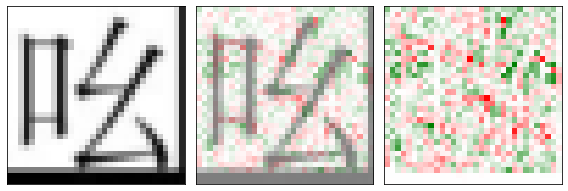

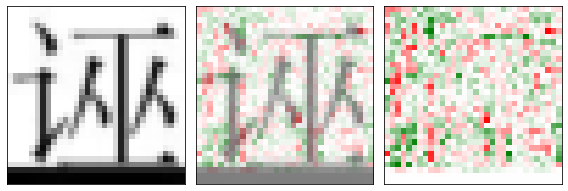

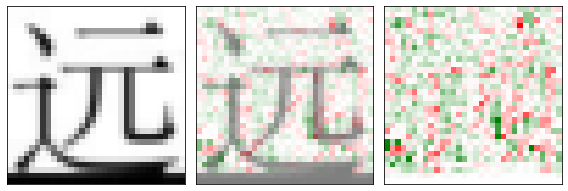

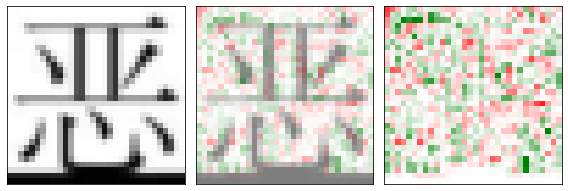

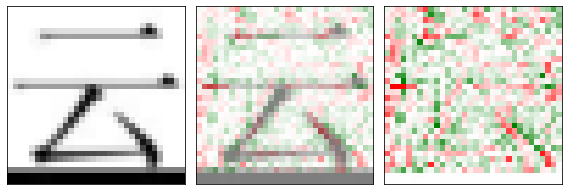

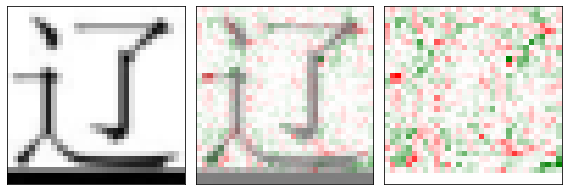

In [263]:
for hanzi in hanzi_list:
    img_path = data_path / 'hanzi_img' / font /(hanzi + '.jpg')
    img = Image.open(str(img_path)).convert('L')
    img_tensor = img_transforms(img).unsqueeze(0).to(device)
    img_tensor.requires_grad = True
    #final_attribution = torch.zeros(img_tensor.shape)
    inputs = tokenizer(hanzi, return_tensors='pt')
    hanzi_id = inputs['input_ids'][0][1].to(device)
    semantic_embedding = lm.embeddings.word_embeddings(hanzi_id).detach().unsqueeze(0)
    cos_model.zero_grad()
    ig = IntegratedGradients(cos_model)
    attribution = ig.attribute(img_tensor, additional_forward_args=semantic_embedding).detach().cpu()  # img is the input image
    img = viz.visualize_image_attr_multiple(
    np.transpose(attribution.squeeze(0).numpy(), (1,2,0)),
    np.transpose(img_tensor.detach().cpu().squeeze(0).repeat(3,1,1).numpy(), (1,2,0)),
    signs=["all", "all", "all"],
    methods=["original_image", "blended_heat_map", "heat_map"],
)
    img[0].savefig(save_dir/(hanzi + '_ig.jpg'))


### Analyze using Grad-CAM ++

In [215]:
import torch
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

In [216]:
class RegModel(torch.nn.Module):
    def __init__(self, model, linear_layer):
        super(RegModel, self).__init__()
        self.model = model
        self.linear_layer = linear_layer
    
    def forward(self, x):
        x = self.model(x)
        x = self.linear_layer(x)
        return x

In [218]:
linear_layer = torch.nn.Linear(768, 768, bias=False)
weights = pickle.load(open(save_dir/'xingsheng_matrix.pkl', 'rb'))
linear_layer.weight.data = torch.from_numpy(weights)

model = model.cpu()
reg_model = RegModel(model, linear_layer)
reg_model.eval()

RegModel(
  (model): Sequential(
    (block1): Sequential(
      (conv1): Conv2d(1, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (maxpool1): AdaptiveMaxPool2d(output_size=8)
    )
    (block2): Sequential(
      (conv2): Conv2d(384, 768, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (maxpool2): AdaptiveMaxPool2d(output_size=2)
    )
    (block3): Sequential(
      (conv3): Conv2d(768, 192, kernel_size=(1, 1), stride=(1, 1))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (droupout): Sequential(
      (0): Reshape()
      (1): Dropout(p=0.1, inplace=False)
    )
  )
  (linear_layer): Linear(in_features=768, out_features=768, bias=False)
)

In [231]:
target_layers = [reg_model.model.block2.leaky_relu]

In [228]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [229]:
lm = BertModel.from_pretrained('bert-base-chinese')
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
lm = lm.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


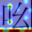

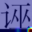

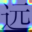

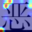

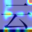

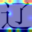

In [232]:
for hanzi in hanzi_list:
    hanzi_img = Image.open(str(data_path / 'hanzi_img' / font / f'{hanzi}.jpg')).convert('L')
    img_tensor = img_transforms(hanzi_img).unsqueeze(0)
    inputs = tokenizer(hanzi, return_tensors='pt')
    hanzi_id = inputs['input_ids'][0][1].to(device)
    semantic_embedding = lm.embeddings.word_embeddings(hanzi_id).detach().cpu()
    semantc_target = [SimilarityToConceptTarget(semantic_embedding)]
    with GradCAM(model=reg_model,
             target_layers=target_layers,
             use_cuda=False) as cam:
        grayscale_cam = cam(input_tensor=img_tensor,
                        targets=semantc_target)[0, :]
    car_cam_image = show_cam_on_image(np.transpose(img_tensor.squeeze(0).repeat(3,1,1).numpy(), (1,2,0)), grayscale_cam, use_rgb=True)
    img = Image.fromarray(car_cam_image)
    img.save(str(save_dir/(hanzi + '_gradcam.jpg')))
    img.show()